# Fully Connected Neural Networks

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

The above code is for compatibility with Python 2. If you are using Python 3 (recommended), you may ignore this.

In [2]:
import tensorflow as tf
import numpy as np

We must import the TensorFlow and numpy packages to be able to use them! We use the prefix "tf" to avoid having to type out the full name every time we want to use a TensorFlow command. Likewise, we prefix all numpy commands with "np".

In [3]:
seed = 1337
tf.set_random_seed(seed)  # Tell TensorFlow to use our seed
np.random.seed(seed)      # Tell NumPy to use our seed

## Loading CIFAR-10 Dataset

In [4]:
import sys
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        if sys.version[0] == '3':
            dict = pickle.load(fo, encoding='bytes')
        elif sys.version[0] == '2':
            dict = pickle.load(fo)
    return dict

This is a helper function that will allow us to load the data.

In [6]:
dataset = unpickle('data_batch_1')
dataset.keys()

dict_keys([b'filenames', b'data', b'batch_label', b'labels'])

We see that the data is stored in a dictionary (a data structure in Python). We are interested in the labels and the data.

In [7]:
dataset[b'data'].shape

(10000, 3072)

There are 10000 images in this "batch", and each is stored in an array of length 3072. Why is this? Hint: The images are 32x32  
Let's plot a random image!

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

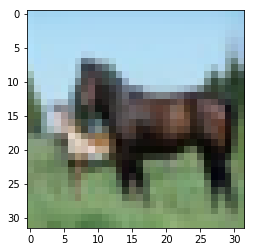

In [9]:
# pick a random number between 0 and 9999
random = 12
img = dataset[b'data'][random].reshape(3,32,32).transpose(1,2,0)
plt.imshow(img);

In [10]:
print(dataset[b'labels'][:100])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


These are the first 100 labels - they are stored as a list of numbers between 0 and 9, where each number corresponds to a class.

In [11]:
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
label_names[dataset[b'labels'][random]]

'horse'

Hence, the selected label is a horse.

We now need to break the dataset up into training and testing sets, so lets do that using the handy `train_test_split()` function from scikit-learn. First we turn the dataset into `x_data` for the actual images and `y_data` for the corresponding labels. Then we randomly split them into training and testing sets.

In [12]:
x_data = np.array(dataset[b'data'])    # The training images
y_data = np.array(dataset[b'labels'])  # The labels for the training images
print("x_data shape:", x_data.shape)
print("y_data shape:", y_data.shape)

x_data shape: (10000, 3072)
y_data shape: (10000,)


In [21]:
n_samples = x_data.shape[0]
indices = np.random.permutation(n_samples)
training_idx, test_idx = indices[:int(0.9*n_samples)], indices[int(0.9*n_samples):]

x_train, x_test = x_data[training_idx,:], x_data[test_idx,:]
y_train, y_test = y_data[training_idx], y_data[test_idx]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print()
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9000, 3072)
x_test shape: (1000, 3072)

y_train shape: (9000,)
y_test shape: (1000,)


We now have separate samples and labels both for training and for testing.

## Making the Fully Connected Neural Network

We know that the CIFAR-10 dataset is composed of 32x32 pictures that are in color (red, green, and blue color channels).  This means that images are in $\mathbb{R}^{32*32*3} = \mathbb{R}^{3072}$. Because there are 10 classes, the predictions are $\hat{y} \in \mathbb{R}^{10}$.

In [16]:
input_length = 3072
num_classes = 10

Now, we need to create the fully connected layers. To make this easier, we will first make a helper function to create a fully connected layer.

Notice that we use `tf.variable_scope()` and `tf.get_variable()` instead of `tf.Variable()`. We use `tf.variable_scope()` to group together all the tensors and variables we define inside it. This does a couple of nice things:

- Anything we define inside the variable scope will have its name prefixed with the name of the scope
- If we try to display the graph, it will look much more organized (remember the tensorflow tutorial?)
- We can control whether we reuse variables or not (more on that in a few sentences)

Using `tf.get_variable()` will create a `tf.Variable` if the variable does not exist yet. If the variable already exists and the variable scope is in reuse mode, it will return the original variable without creating a new one. If not in reuse mode, it will throw an error, preventing us from accidentally duplicating variables
For these reasons using `tf.variable_scope()` is a great organizational tool and helps us avoid making mistakes by preventing accidental variable duplication. If we had used `tf.Variable()`, it would ignore these duplication rules and always make a new variable, adding a suffix onto the name if it already existed.

**In summary: Always keep your code organized and safe from sneaky bugs by using `tf.variable_scope()`, and always use `tf.get_variable()` instead of `tf.Variable()`.**

In [22]:
def fc(input_tensor, output_features, name='FC', func=tf.nn.relu):
    """Creates a Fully Connected Layer

    Args:
        input_tensor:  Tensor of shape `[batch, features]` that this FC layer uses as its input features.
        output_features:  The number of features that the layer will output.
        name:  The name of the Fully Connected layer. Will use this to define the `tf.variable_scope()`.
        func:  The activation function to use. If `None`, uses ReLU.
    
    Returns:
        A Tensor representing the output feature activations. Will have shape `[None, output_features]`.
    """
    input_features = int(input_tensor.shape[1])  # Get the number of features for the input tensor
    with tf.variable_scope(name):
        w = tf.get_variable('W', initializer=tf.truncated_normal(
            shape=[input_features, output_features],
            stddev=0.1))
        b = tf.get_variable('B', initializer=tf.zeros([output_features]))
        return func(tf.matmul(input_tensor, w) + b, name='Activations')

Here, we declare all our inputs, outputs, and parameters.

In [23]:
tf.reset_default_graph()  # Clear the graph to avoid errors from reusing variables

with tf.variable_scope('Inputs'):
    x = tf.placeholder(tf.float32, [None, input_length], name='x')
    y = tf.placeholder(tf.int64, [None,], name='y')  # Last time we one-hot encoded our labels. Now we won't.

with tf.variable_scope('Hidden-Layers'):
    hidden1 = fc(x, 512, 'FC1')
    hidden2 = fc(hidden1, 512, 'FC2')
    hidden3 = fc(hidden2, 512, 'FC3')
    
with tf.variable_scope('Softmax'):
    w = tf.get_variable('W', initializer=tf.truncated_normal(shape=[512, num_classes], stddev=0.1))
    b = tf.get_variable('B', initializer=tf.zeros([num_classes]))
    scores = tf.matmul(hidden3, w) + b
    # Predicted probability vectors for each sample in the batch, shape = `[None, 10]`
    pred = tf.nn.softmax(scores)

with tf.variable_scope('Optimization'):
    # Last time we used the regular cross entropy function, but this time we use the "sparse" version. 
    # That's because this version takes care of turning the labels into one hot encodings for us!
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores))
    correct = tf.equal(tf.argmax(pred, axis=1), y)           # boolean 1-D Tensor of if pred was correct
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))  # scalar (0-D) Tensor of the average accuracy
    
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)  # Op that steps loss towards minimum
    
init = tf.global_variables_initializer()  # Op that initializes variables

## Training the Network
We already split that dataset into training and testing sets. Now we just need to feed the training set into the model and perform gradient descent. Because the training set is large (9000 images), we will feed in only a subset of the training set at a time for each batch.

*Side note: When using the whole dataset in a batch, it is called "Gradient Descent". When using a subset of the dataset in the batch, this is called "Mini-Batch Gradient Descent". When the batch size is set to 1, it is called "Stochastic Gradient Descent". People mix up these terms, so if you hear someone saying "use SGD", they probably are referring to Mini-Batch Gradient Descent rather than Stochastic Gradient Descent. Even in academic papers, people confuse these!*

In [27]:
sess = tf.InteractiveSession()
sess.run(init)  # Initialize all `tf.Variable` objects

In [28]:
n_epochs = 10    # Do 10 full passes through the dataset before we quit training
batch_size= 256  # Feed in only 256 images in a single batch instead of all 9,000

training_size = x_train.shape[0]

from math import ceil
n_batches = ceil(training_size / batch_size)

for j in range(n_epochs):
    perm = np.random.permutation(training_size)  # Every epoch, get a new set of batches
    total_loss = 0
    total_accuracy = 0
    for i in range(0, training_size, batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        _, batch_loss, batch_accuracy = sess.run([train_step, loss, accuracy], feed_dict={x:x_batch, y:y_batch})
        total_loss += batch_loss
        total_accuracy += batch_accuracy
    if j%10 == 9 or j==n_epochs-1 or j==0:
        print("epoch %3d, loss=%6f, accuracy=%.2f%%" % (j+1, total_loss/n_batches, 100*round(total_accuracy/n_batches, 4)))

epoch   1, loss=1862.446064, accuracy=13.30%
epoch  10, loss=28.634450, accuracy=33.31%


Generate some predictions!

Prediction: truck


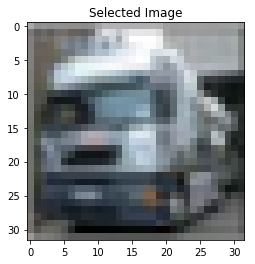

In [30]:
# pick a random image from our test set (1000 images)
random = 67
sample = x_test[random]
plt.imshow(sample.reshape(3,32,32).transpose(1,2,0));
plt.title('Selected Image')

print('Prediction:', label_names[sess.run(tf.argmax(pred, axis=1), feed_dict={x:[sample]})[0]])